In [6]:
import csv
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy import signal
from scipy.optimize import leastsq

from scipy.fftpack import fft

import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
def linear_fit(x, y):
    # y = a + bX
    
    # b
    x_hat = np.mean(x)
    y_hat = np.mean(y)
    b = ( np.sum((x-x_hat) * (y-y_hat)) ) / np.sum((x-x_hat)**2) 

    # a
    a = y_hat - (b*x_hat)

    return a, b

def lp_filter(cutoff, sig, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    y = signal.lfilter(b, a, sig)
    return y

def delin(y):
    x = np.array(range(0,len(y)))
    a,b = linear_fit(x,y)
    return y-(a+b*x)

def normalize(y, fit=False, lowpass=False):
    x = np.array(range(0,len(y)))
    y = 2 * ( (y - np.min(y)) / (np.max(y) - np.min(y)) ) - 1
    return y

def rms(y):
    return np.sqrt(np.mean(y**2))    

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

In [57]:
df = pd.read_csv('events/normal_breathing_4.csv')
df_temp = df.where(df['type'] == 'temperature').dropna()
df_pressure = df.where(df['type'] == 'pressure').dropna()
df_gt = pd.read_csv('events/normal_breathing_4_gt.csv')

In [116]:
# pressure: remove linear trend and normalize
df_pressure['filtered_value'] = normalize(delin(df_pressure['value']))

# temperature: remove linear trend, normalize and invert
df_temp['filtered_value'] = -normalize(delin(df_temp['value']))

# ground truth: normalize and invert
df_gt['filtered_value'] = -normalize(df_gt['Arb'])



df_gt.head(100)

,Time,Arb,filtered_value,timedelta,datetime
0,'-0:0:0.63,796,-0.403950,0 days 00:00:00.630000,2021-02-09 17:10:08.667
1,'-0:0:0.62,798,-0.411131,0 days 00:00:00.620000,2021-02-09 17:10:08.657
2,'-0:0:0.61,799,-0.414722,0 days 00:00:00.610000,2021-02-09 17:10:08.647
3,'-0:0:0.6,800,-0.418312,0 days 00:00:00.600000,2021-02-09 17:10:08.637
4,'-0:0:0.59,800,-0.418312,0 days 00:00:00.590000,2021-02-09 17:10:08.627
...,...,...,...,...,...
95,'0:0:0.32,954,-0.971275,0 days 00:00:00.320000,2021-02-09 17:10:08.357
96,'0:0:0.33,954,-0.971275,0 days 00:00:00.330000,2021-02-09 17:10:08.367
97,'0:0:0.34,953,-0.967684,0 days 00:00:00.340000,2021-02-09 17:10:08.377
98,'0:0:0.35,952,-0.964093,0 days 00:00:00.350000,2021-02-09 17:10:08.387


In [117]:
# convert to datetime
df_temp['datetime'] = pd.to_datetime(df_temp['datetime'], infer_datetime_format=True)
df_pressure['datetime'] = pd.to_datetime(df_pressure['datetime'], infer_datetime_format=True)

In [121]:

# offset to line up the peaks... eye ball method
offset = timedelta(seconds=-1)

# set timestamps
startdate = df_pressure.iloc[0]['datetime'] - offset

def dt_ti(time_str):
    time_str = time_str.replace("'", '')
    spt = time_str.split(':')
    h = int(spt[0])
    m = int(spt[1])
    s = float(spt[2])
    delta = timedelta(hours=h, minutes=m, seconds=s)
    return delta


df_gt['timedelta'] = df_gt['Time'].apply(dt_ti)
df_gt['datetime'] = startdate + df_gt['timedelta']
df_gt.head()

,Time,Arb,filtered_value,timedelta,datetime
0,'-0:0:0.63,796,-0.403950,0 days 00:00:00.630000,2021-02-09 17:10:08.667
1,'-0:0:0.62,798,-0.411131,0 days 00:00:00.620000,2021-02-09 17:10:08.657
2,'-0:0:0.61,799,-0.414722,0 days 00:00:00.610000,2021-02-09 17:10:08.647
3,'-0:0:0.6,800,-0.418312,0 days 00:00:00.600000,2021-02-09 17:10:08.637
4,'-0:0:0.59,800,-0.418312,0 days 00:00:00.590000,2021-02-09 17:10:08.627


In [122]:
# trim times
start = datetime(2021, 2, 9, 17, 10, 11, 0)
end = datetime(2021, 2, 9, 17, 10, 34, 0)

df_pressure_trim = df_pressure.where(df_pressure['datetime'] > start).where(df_pressure['datetime'] < end)
# df_pressure_trim = df_pressure_trim.resample('40ms', on='datetime').mean()

df_temp_trim = df_temp.where(df_temp['datetime'] > start).where(df_temp['datetime'] < end)
# df_temp_trim = df_temp_trim.resample('40ms', on='datetime').mean()

df_gt_trim = df_gt.where(df_gt['datetime'] > start).where(df_gt['datetime'] < end)
# df_temp_trim = df_temp_trim.resample('40ms', on='datetime').mean()

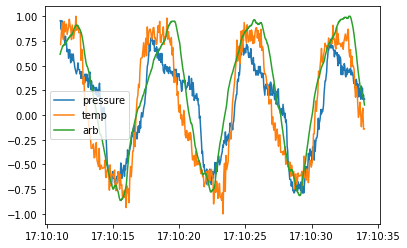

In [123]:
plt.plot(df_pressure_trim['datetime'], df_pressure_trim['filtered_value'], label='pressure')
plt.plot(df_temp_trim['datetime'], df_temp_trim['filtered_value'], label='temp')
plt.plot(df_gt_trim['datetime'], df_gt_trim['filtered_value'], label='arb')

plt.legend()

Text(0.5, 1.0, 'Temp/Gt')

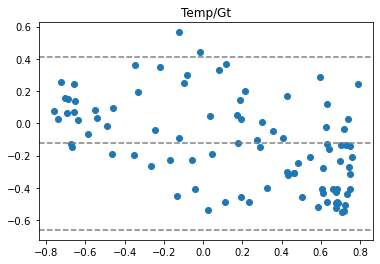

In [112]:
df_pressure_resampled = df_pressure_trim.resample('250ms', on='datetime').mean()
df_temp_resampled = df_temp_trim.resample('250ms', on='datetime').mean()
df_gt_resampled = df_gt_trim.resample('250ms', on='datetime').mean()

bland_altman_plot(df_pressure_resampled['filtered_value'], df_gt_resampled['filtered_value'])
plt.title('Temp/Gt')

Text(0.5, 1.0, 'Pressure/Gt')

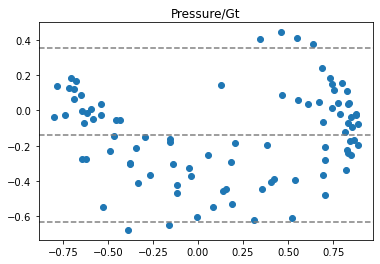

In [113]:
bland_altman_plot(df_temp_resampled['filtered_value'], df_gt_resampled['filtered_value'])
plt.title('Pressure/Gt')

Text(0.5, 1.0, 'Temp/Pressure')

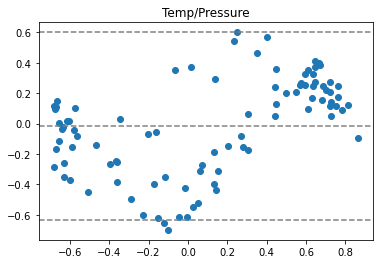

In [114]:
bland_altman_plot(df_temp_resampled['filtered_value'], df_pressure_resampled['filtered_value'])
plt.title('Temp/Pressure')